# Proyecto Pronóstico y predicción

La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con el cliente basada en datos analíticos.
Uno de los problemas más comunes que enfrentan los gimnasios y otros servicios es la pérdida de clientes. ¿Cómo descubres si un cliente ya no está contigo? Puedes calcular la pérdida en función de las personas que se deshacen de sus cuentas o no renuevan sus contratos. Sin embargo, a veces no es obvio que un cliente se haya ido: puede que se vaya de puntillas.
Los indicadores de pérdida varían de un campo a otro. Si un usuario compra en una tienda en línea con poca frecuencia pero con regularidad, no se puede decir que ha huido. Pero si durante dos semanas no ha abierto un canal que se actualiza a diario, es motivo de preocupación: es posible que tu seguidor se haya aburrido y te haya abandonado.
En el caso de un gimnasio, tiene sentido decir que un cliente se ha ido si no viene durante un mes. Por supuesto, es posible que estén en Cancún y retomen sus visitas cuando regresen, pero ese no es un caso típico. Por lo general, si un cliente se une, viene varias veces y luego desaparece, es poco probable que regrese.
Con el fin de combatir la cancelación, Model Fitness ha digitalizado varios de sus perfiles de clientes. Tu tarea consiste en analizarlos y elaborar una estrategia de retención de clientes.
Tienes que:
- Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente
- Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales
- Analizar los factores que más impactan la pérdida
- Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:
    - Identificar a los grupos objetivo
    - Sugerir medidas para reducir la rotación
    - Describir cualquier otro patrón que observes con respecto a la interacción con los clientes


In [52]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Tabla de contenidos <a id='back'></a>

1. [Descarga de datos y preparación](#descarga_datos)
2. [Análisis exploratorio de datos (EDA)](#eda)
3. [Modelo para predecir la cancelación de usuarios](#modelo_cancelacion)
4. [Clústeres de usuarios](#clusters)
5. [Conclusiones y recomendaciones](#conclusiones_recomendaciones)

## Descarga de datos y preparación <a id="descarga_datos"></a>

Vamos a cargar los datos del dataset `gym_churn_us.csv`

In [27]:
# Carga los archivos de datos
data = pd.read_csv('../data/gym_churn_us.csv')

# Verificamos que los datos se hayan cargado correctamente
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Vamos a estudiar los datos que contiene nuestro dataset y verificar que los tipos de datos sean correctos para nuestro análisis

In [28]:
# Imprimimos la información general/resumen sobre nuestro dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Nuestro dataset `data` que son los datos sobre la cancelación de un mes en concreto e información del mes que lo precedía de Model Fitness, contiene los siguientes datos:

- `Churn`: la cancelación para el mes en cuestión
- Campos de dataset actuales:
    - `gender`: género del cliente
    - `Near_Location`: si el usuario vive o trabaja en el vecindario donde se encuentra el gimnasio
    - `Partner`: si el usuario es un trabajador de una compañía asociada (el gimnasio tiene empresas asociadas cuyos empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes)
    - `Promo_friends`: si el usuario originalmente se inscribió mediante una oferta "trae a un amigo" (se utilizó el código promocional de un amigo cuando pagaron el primer abono)
    - `Phone`: si el usuario aportó el número de teléfono
    - `Age`: edad del cliente
    - `Lifetime`: el tiempo (en meses) desde que el usuario llegó por primera vez al gimnasio
- Datos del registro de visitas y compras y datos sobre el estado actual de la membresía
    - `Contract_period`: periodo del contrato (1 mes, 3 meses, 6 meses o 1 año)
    - `Month_to_end_contract`: los meses que faltan hasta que expire el contrato
    - `Group_visits`: si el usuario participa en sesiones grupales
    - `Avg_class_frequency_total`: frecuencia media de visitas por semana a lo largo de la vida del cliente
    - `Avg_class_frequency_current_month`: frecuencia media de visitas por semana durante el mes en curso
    - `Avg_additional_charges_total`: cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos deportivos, cosméticos, masajes, etc.

In [29]:
# Verificamos que no haya datos duplicados en el dataset
print('Datos duplicados en el dataset:', data.duplicated().sum())

Datos duplicados en el dataset: 0


In [30]:
# Se imprime una descripción de los datos numericos
data[['Age', 'Lifetime', 'Contract_period', 'Month_to_end_contract', 'Avg_class_frequency_current_month', 'Avg_class_frequency_total', 'Avg_additional_charges_total']].describe()

,Age,Lifetime,Contract_period,Month_to_end_contract,Avg_class_frequency_current_month,Avg_class_frequency_total,Avg_additional_charges_total
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,29.184250,3.724750,4.681250,4.322750,1.767052,1.879020,146.943728
std,3.258367,3.749267,4.549706,4.191297,1.052906,0.972245,96.355602
min,18.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.148205
25%,27.000000,1.000000,1.000000,1.000000,0.963003,1.180875,68.868830
50%,29.000000,3.000000,1.000000,1.000000,1.719574,1.832768,136.220159
75%,31.000000,5.000000,6.000000,6.000000,2.510336,2.536078,210.949625
max,41.000000,31.000000,12.000000,12.000000,6.146783,6.023668,552.590740


#### Conclusiones del dataset

Al ver la muestra y resumen del dataset, no encontramos duplicados ni ausentes. Sin embargo es necesario ajustar los nombres de las columnas al estilo snake_case para facilitar el uso y llamado en procesos posteriores, tambien es necesario ajustar las columnas con opciones 1 y 0 a `boolean` para optimizar su uso. Por último, gracias a la descripción de los datos númericos vemos que la mayoria de las columnas no presentan datos outliers, las unicas a tener cierta precaución serian `contract_period`, `month_to_end_contract` y `avg_additional_charges_total` ya que sus medias tienen diferencias un poco significativas con sus medianas.

### Corregir datos

In [31]:
# Cambiar los nombres de las columnas
data.columns = data.columns.str.lower()
# Cambiar el tipo de dato de las columnas identificadas a bool
columnas_bool = ['near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
for column in columnas_bool:
    data[column] = data[column].astype(bool)
data.info()

Con estas correcciones, nuestro dataset está listo para nuestro análisis.

## Análisis exploratorio de datos (EDA)<a id="eda"></a>

Vamos a realizar las siguientes tareas en esta fase:

- Observa el dataset: ¿contiene alguna característica ausente? Estudia los valores promedio y la desviación estándar.
- Observa los valores medios de las características en dos grupos: para los que se fueron (cancelación) y para los que se quedaron
- Trazar histogramas de barras y distribuciones de características para aquellos que se fueron (cancelación) y para los que se quedaron.
- Crea una matriz de correlación y mostrarla.

In [32]:
# Estudiar los valores promedio y la desviación estándar
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [33]:
# Observar los valores medios de la caracteristicas por grupos
data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


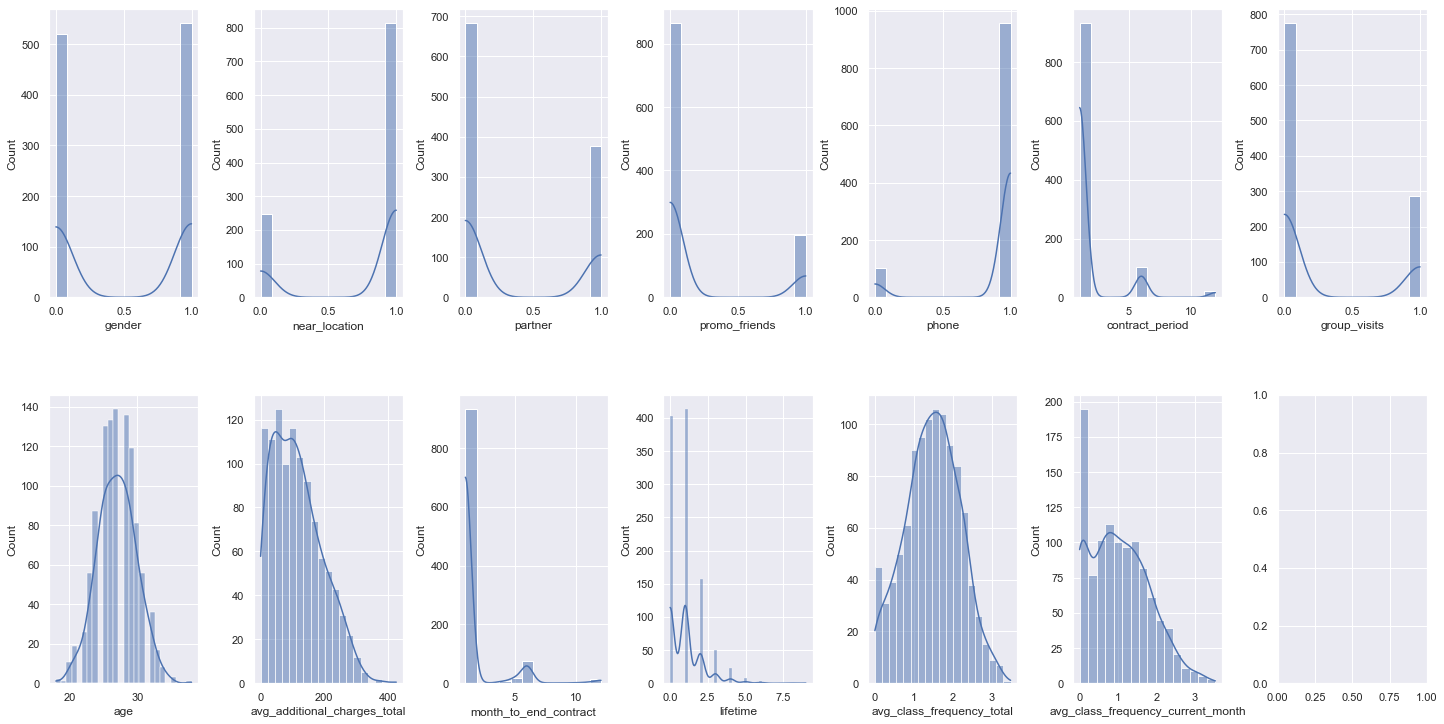

In [39]:
# Datos de clientes que se quedaron y que se fueron
data_stay = data.query('churn == 1').drop(columns=['churn'])
data_left = data.query('churn == 0').drop(columns=['churn'])

# Graficas de clientes que se quedaron
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20,10))
index = 0
axs = axs.flatten()
for k,v in data_stay.items():
    sns.histplot(data=data, x=v, ax=axs[index], kde=True)
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

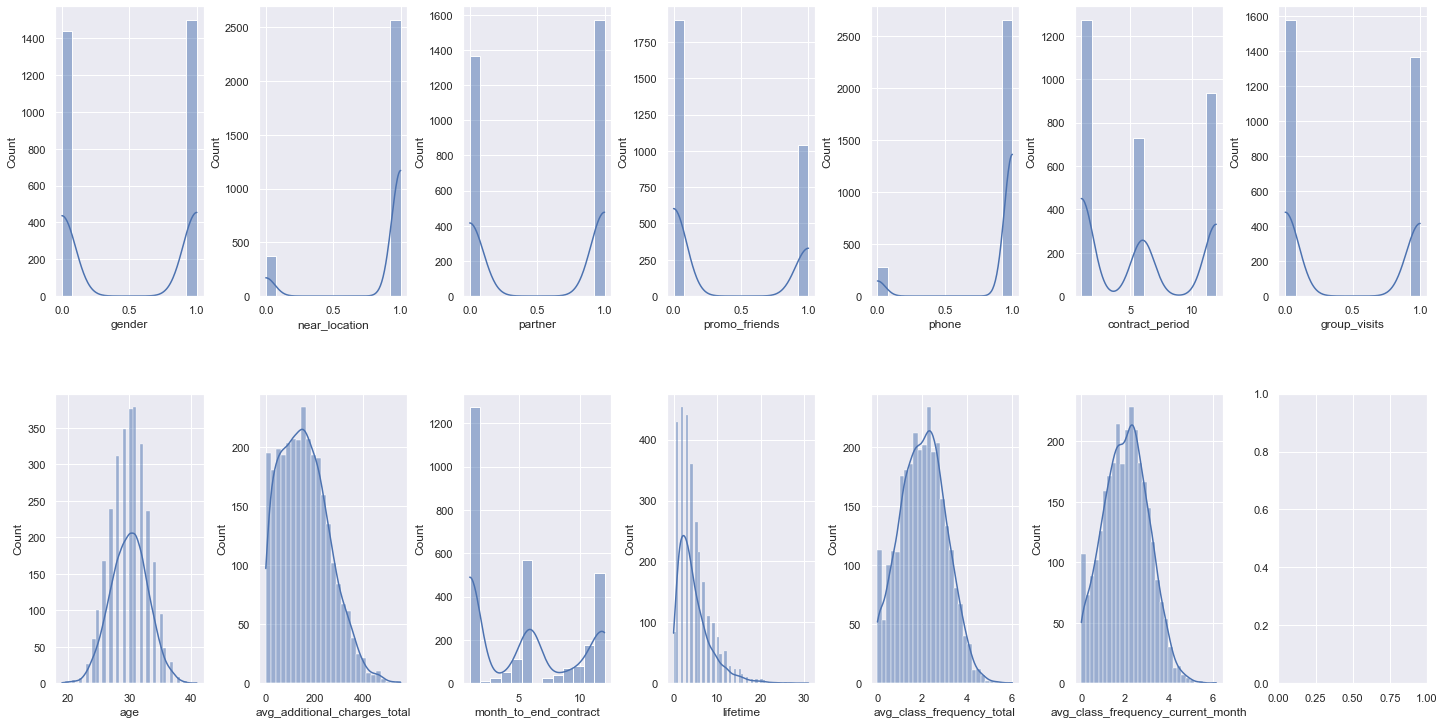

In [40]:
# Graficas de clientes que se fueron
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20,10))
index = 0
axs = axs.flatten()
for k,v in data_left.items():
    sns.histplot(data=data, x=v, ax=axs[index], kde=True)
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

<AxesSubplot:>

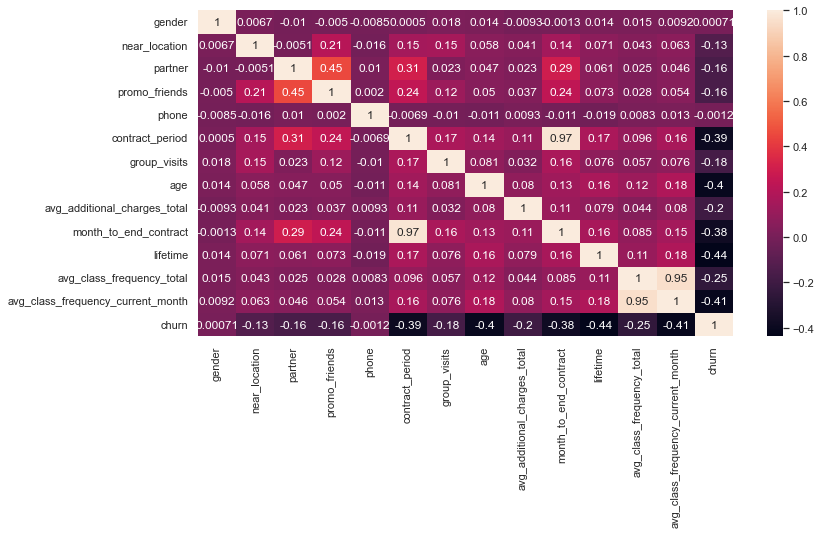

In [35]:
# Matriz de correlacion
cm = data.corr()
sns.set(rc={"figure.figsize":(12, 6)})
sns.heatmap(cm, annot = True)

## Modelo para predecir la cancelación de usuarios<a id="modelo_cancelacion"></a>

Para esta fase se debe crear un modelo de clasificación binaria para clientes donde la característica objetivo es la marcha del usuario el mes siguiente.
Se deben cumplir los siguientes pasos:

- Divide los datos en conjuntos de entrenamiento y validación
- Entrena el modelo en el set de entrenamiento con dos métodos:
    - Regresión logística
    - Bosque aleatorio
- Evalúa la exactitud, precisión y recall para ambos modelos utilizando los datos de validación. Utilízalos para comparar los modelos. ¿Qué modelo dio mejores resultados?

In [44]:
# Dividimos los datos en caracteristicas y variable objetivo
X = data.drop('churn', axis = 1)
y = data['churn']

# divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [49]:
# define el algoritmo del modelo
rf_model = RandomForestClassifier(n_estimators = 100)

# entrena tu modelo
rf_model.fit(X_train, y_train)

# utiliza el modelo entrenado para hacer previsiones
y_pred = rf_model.predict(X_test)

In [54]:
# Metricas
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('Exactitud:', acc)
print('Precision:', precision)
print('Recall:', recall)

Exactitud: 0.92125
Precision: 0.8534031413612565
Recall: 0.8232323232323232
